# Individual Neuron Development

In [1]:
import sys
sys.path.insert(0, '/Users/amilmerchant/NEST/install/lib/python2.7/site-packages')
import nest
import pylab
import math

In [2]:
nest.ResetKernel()
nest.SetKernelStatus({"local_num_threads": 4})
nest.SetKernelStatus({"resolution": 0.2})

In [3]:
e_dict = {'V_m': -55.,
          'V_th': -50.,
          'V_peak': 0.,
          'V_reset': -55.,
          'C_m': 500.,
          'g_L': 25.,
          'E_L':-70.,
          'E_rev': [0., -70., 0.],
          'tau_rise' : [0.2, 0.2, 2.],
          'tau_decay' : [2., 5., 100.],
          'a' : 0.,
          'b' : 0.,
          'Delta_T' : 0.,
          'tau_w' : 1000.,
          't_ref' : 2.
         }

In [4]:
i_dict = {'V_m' : -55.,
          'V_th': -50.,
          'V_peak': 0.,
          'V_reset': -55.,
          'C_m': 200.,
          'g_L': 20.,
          'E_L':-70.,
          'E_rev': [0., -70., 0.],
          'tau_rise' : [0.2, 0.2, 2.],
          'tau_decay' : [2., 5., 100.],
          'a' : 0.,
          'b' : 0.,
          'Delta_T' : 0.,
          'tau_w' : 1000.,
          't_ref' : 1.
         }

In [5]:
N_e = 1600
N_i = 400

Cxe = nest.Create("aeif_cond_beta_multisynapse", N_e, e_dict)
Cxi = nest.Create("aeif_cond_beta_multisynapse", N_i, i_dict)


Cxe_L = Cxe[:240]
Cxe_R = Cxe[240:480]
Cxe_non = Cxe[480:]

In [6]:
N_cd = 250 #250 GABAergic neurons for each population
CD_L = nest.Create("aeif_cond_beta_multisynapse", N_cd, e_dict)
N_snr = 250 #250 GABAergic neurons for each population
SNr_L = nest.Create("aeif_cond_beta_multisynapse", N_snr, e_dict)

In [7]:
N_sce = 250 #250 GABAergic neurons for each population
SCe_L = nest.Create("aeif_cond_beta_multisynapse", N_sce, e_dict)
N_sci = 250
SCi = nest.Create("aeif_cond_beta_multisynapse", N_sci, i_dict)

In [8]:
N_gpe = 2500
GPe_L = nest.Create("aeif_cond_beta_multisynapse", N_gpe, e_dict)
N_stn = 2500
STN_L = nest.Create("aeif_cond_beta_multisynapse", N_stn, e_dict)

## Synapses

In [9]:
nest.CopyModel("static_synapse", "eAMPA", 
               {"weight": 1.0, 'receptor_type': 1,  'delay' : 0.2})
nest.CopyModel("static_synapse", "eGABA", 
               {"weight": 1.0, 'receptor_type': 2, 'delay': 0.2})
nest.CopyModel("static_synapse", "eNMDA", 
               {"weight": 1.0, 'receptor_type': 3, 'delay': 0.2})

In [10]:
cor_back = nest.Create('poisson_generator', 1, {'rate': 2400.})

parrot_cxe = nest.Create('parrot_neuron', 1600)
parrot_cxi = nest.Create('parrot_neuron', 400)

conn_dict = {'rule': 'all_to_all'}

nest.Connect(cor_back, parrot_cxe, conn_dict, {'model': 'static_synapse'})
nest.Connect(cor_back, parrot_cxi, conn_dict, {'model': 'static_synapse'})

In [11]:
correction = (1 + 1 * math.exp(-0.062 * -55) / 3.57)

w_plus = 1.7
f = float(len(Cxe_L)) /len(Cxe)
w_minus = 1 - f * (w_plus - 1) / (1 - f)

In [12]:
nest.Connect(parrot_cxe, Cxe, {'rule': 'one_to_one'}, {'model': 'eAMPA', 'weight': 2.1})
nest.Connect(parrot_cxi, Cxi, {'rule': 'one_to_one'}, {'model': 'eAMPA', 'weight': 1.62 })

### External Connections

In [13]:
nest.Connect(Cxe_L, SCe_L, conn_dict, {'model': 'eAMPA', 'weight': 3.5})
nest.Connect(Cxe_L, CD_L, conn_dict, {'model': 'eAMPA', 'weight': 3.}) # 1 - 4.5 nS

### Internal Connections

In [14]:
nest.Connect(Cxe_L, Cxe_L, conn_dict, {'model': 'eAMPA', 'weight': 0.085})
nest.Connect(Cxe_L, Cxe_L, conn_dict, {'model': 'eNMDA', 'weight': 0.2805 / correction })

nest.Connect(Cxe, Cxi, conn_dict, {'model': 'eAMPA', 'weight': 0.04 })
nest.Connect(Cxe, Cxi, conn_dict, {'model': 'eNMDA', 'weight': 0.13 / correction })

nest.Connect(Cxe_L, Cxe_non, conn_dict, {'model': 'eAMPA', 'weight': 0.05})
nest.Connect(Cxe_L, Cxe_non, conn_dict, {'model': 'eNMDA', 'weight': 0.165 / correction })

nest.Connect(Cxe_non, Cxe_L, conn_dict, {'model': 'eAMPA', 'weight': 0.043825})
nest.Connect(Cxe_non, Cxe_L, conn_dict, {'model': 'eNMDA', 'weight': 0.14462 / correction })

nest.Connect(Cxe_non, Cxe_non, conn_dict, {'model': 'eAMPA', 'weight': 0.05})
nest.Connect(Cxe_non, Cxe_non, conn_dict, {'model': 'eNMDA', 'weight': 0.165/ correction })

nest.Connect(Cxi, Cxe, conn_dict, {'model': 'eGABA', 'weight': 1.3 })
nest.Connect(Cxi, Cxi, conn_dict, {'model': 'eGABA', 'weight': 1.0 })

In [15]:
coherence = 25.6
u_a_factor = 60
u_b_factor = 20

u_a = 20 + u_a_factor * coherence / 100.
u_b = 20 - u_b_factor * coherence / 100.


input_left = nest.Create('poisson_generator', 1, {'rate': u_a, 'start': 100.})
input_right = nest.Create('poisson_generator', 1, {'rate': u_b, 'start': 100.})

#nest.Connect(input_left, Cxe_L, conn_dict, {'model': 'eAMPA', 'weight': 2.1 })

# Basal Ganglia

### Internal Connections

In [16]:
nest.Connect(CD_L, CD_L, conn_dict, {'model': 'eGABA', 'weight': 1.0})

nest.Connect(CD_L, SNr_L, conn_dict, {'model': 'eGABA', 'weight': 3.0})

nest.Connect(CD_L, GPe_L, conn_dict, {'model': 'eGABA', 'weight': 5.0}) # 4.0

nest.Connect(GPe_L, GPe_L, {'rule': 'pairwise_bernoulli', 'p': 0.05}, {'model': 'eGABA', 'weight': 1.5})

nest.Connect(GPe_L, STN_L, {'rule': 'pairwise_bernoulli', 'p': 0.02}, {'model': 'eGABA', 'weight': 0.8}) # 0.6

nest.Connect(GPe_L, SNr_L, conn_dict, {'model': 'eGABA', 'weight': 0.08})

# nest.Connect(STN_L, GPe_L, {'rule': 'pairwise_bernoulli', 'p': 0.05}, {'model': 'eAMPA', 'weight': 0.05})
nest.Connect(STN_L, GPe_L, {'rule': 'pairwise_bernoulli', 'p': 0.05}, {'model': 'eNMDA', 'weight': 2.0 / correction})

nest.Connect(STN_L, SNr_L, conn_dict, {'model': 'eNMDA', 'weight': 0.06 / correction})

### External Connections

In [17]:
nest.Connect(SNr_L, SCe_L, conn_dict, {'model': 'eGABA', 'weight': 2.5})

In [18]:
cd_back = nest.Create('poisson_generator', 1, {'rate': 800.})
gpe_ampa_back = nest.Create('poisson_generator', 1, {'rate': 3200.})
gpe_gaba_back = nest.Create('poisson_generator', 1, {'rate': 2000.})
stn_back = nest.Create('poisson_generator', 1, {'rate': 4000.})
snr_back = nest.Create('poisson_generator', 1, {'rate': 800.})

conn_dict = {'rule': 'all_to_all'}

In [19]:
nest.Connect(cd_back, CD_L, conn_dict, {'model': 'eAMPA', 'weight': 4.0})

nest.Connect(gpe_ampa_back, GPe_L, conn_dict, {'model': 'eAMPA', 'weight': 3.2})

nest.Connect(gpe_gaba_back, GPe_L, conn_dict, {'model': 'eGABA', 'weight': 2.0})
                                               
nest.Connect(stn_back, STN_L, conn_dict, {'model': 'eAMPA', 'weight': 1.6})
                                                        
nest.Connect(snr_back, SNr_L, conn_dict, {'model': 'eAMPA', 'weight': 14.0})

# Superior Colliculus

In [20]:
nest.Connect(SCe_L, SCe_L, conn_dict, {'model': 'eNMDA', 'weight': 1.5 / correction })
nest.Connect(SCe_L, SCi, conn_dict, {'model': 'eNMDA', 'weight': 0.7 / correction })
nest.Connect(SCe_L, Cxi, conn_dict, {'model': 'eNMDA', 'weight': 0.11 / correction }) 
nest.Connect(SCe_L, Cxe_L, conn_dict, {'model': 'eNMDA', 'weight': 0.05 / correction })

# Include short term facilitation
nest.Connect(SCi, SCe_L, conn_dict, {'model': 'eGABA', 'weight': 2.5})

In [21]:
sc_back = nest.Create('poisson_generator', 1, {'rate': 800.})

parrot_scel = nest.Create('parrot_neuron', 250)
parrot_scer = nest.Create('parrot_neuron', 250)
parrot_sci = nest.Create('parrot_neuron', 250)

nest.Connect(sc_back, parrot_scel, conn_dict, {'model': 'static_synapse'})
nest.Connect(sc_back, parrot_scer, conn_dict, {'model': 'static_synapse'})
nest.Connect(sc_back, parrot_sci, conn_dict, {'model': 'static_synapse'})

In [22]:
nest.Connect(parrot_scel, SCe_L, {'rule': 'one_to_one'}, {'model': 'eAMPA', 'weight': 0.4864})
#nest.Connect(parrot_sci, SCi, {'rule': 'one_to_one'}, {'model': 'eAMPA', 'weight': 1.0})

# Run the Model

In [23]:
multis = []
for i in Cxe:
    multimeter = nest.Create("multimeter")
    multis.append(multimeter)
    nest.SetStatus(multimeter, {"withtime":True, "record_from":["V_m"]})
    nest.Connect(multimeter, [i])

spikedetector = nest.Create("spike_detector",
                params={"withgid": True, "withtime": True})
nest.Connect(Cxe, spikedetector)

In [24]:
import nest.raster_plot

pops = [Cxe_L, Cxe, Cxi, CD_L, GPe_L, STN_L,
        SNr_L, SCe_L, SCi]
sds = []
for i in range(len(pops)):
    sds.append(nest.Create("spike_detector",
                params={"withtime": True}))
    nest.Connect(pops[i], sds[i])

In [25]:
import time
start = time.time()
sim_time = 500.

In [26]:
nest.Simulate(sim_time)
end = time.time()
print end - start

62.3559648991


In [27]:
import pylab
pylab.ion()

names = ["Cxe_L", "Cxe", "Cxi", "CD_L", "GPe_L", 
         "STN_L", "SNr_L", "SCe_L", "SCi"]

In [28]:
import matplotlib.pyplot as plt

frame = 50 # 50 ms firing rate interval

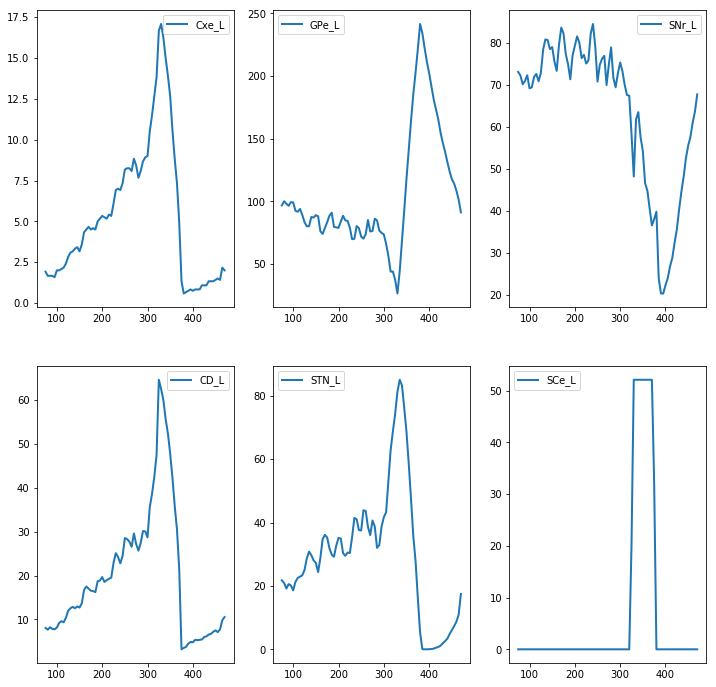

In [29]:
width = 12
height = 12
plt.figure(figsize=(width, height))

offset = 50

plt.subplot(231)
for i in range(0,1):
    times = []
    values = []
    for j in range(offset + frame / 2 , (int) (sim_time - frame / 2), frame / 10):
        times.append(j)
        dsd = nest.GetStatus(sds[i],keys="events")[0]["times"]
        count = sum(1 if x <= j + frame / 2. and x >= j - frame / 2. else 0 for x in dsd)
        values.append(1000. * count / frame / len(pops[i]))
    plt.plot(times, values, lw=2, label= names[i])
plt.legend()

plt.subplot(234)
for i in range(3,4):
    times = []
    values = []
    for j in range(offset + frame / 2 , (int) (sim_time - frame / 2), frame / 10):
        times.append(j)
        dsd = nest.GetStatus(sds[i],keys="events")[0]["times"]
        count = sum(1 if x <= j + frame / 2. and x >= j - frame / 2. else 0 for x in dsd)
        values.append(1000. * count / frame / len(pops[i]))
    plt.plot(times, values, lw=2, label= names[i])
plt.legend()

plt.subplot(232)
for i in range(4,5):
    times = []
    values = []
    for j in range(offset + frame / 2 , (int) (sim_time - frame / 2), frame / 10):
        times.append(j)
        dsd = nest.GetStatus(sds[i],keys="events")[0]["times"]
        count = sum(1 if x <= j + frame / 2. and x >= j - frame / 2. else 0 for x in dsd)
        values.append(1000. * count / frame / len(pops[i]))
    plt.plot(times, values, lw=2, label= names[i])
plt.legend()

plt.subplot(235)
for i in range(5,6):
    times = []
    values = []
    for j in range(offset + frame / 2 , (int) (sim_time - frame / 2), frame / 10):
        times.append(j)
        dsd = nest.GetStatus(sds[i],keys="events")[0]["times"]
        count = sum(1 if x <= j + frame / 2. and x >= j - frame / 2. else 0 for x in dsd)
        values.append(1000. * count / frame / len(pops[i]))
    plt.plot(times, values, lw=2, label= names[i])
plt.legend()

plt.subplot(233)
for i in range(6,7):
    times = []
    values = []
    for j in range(offset + frame / 2 , (int) (sim_time - frame / 2), frame / 10):
        times.append(j)
        dsd = nest.GetStatus(sds[i],keys="events")[0]["times"]
        count = sum(1 if x <= j + frame / 2. and x >= j - frame / 2. else 0 for x in dsd)
        values.append(1000. * count / frame / len(pops[i]))
    plt.plot(times, values, lw=2, label= names[i])
plt.legend()

plt.subplot(236)
for i in range(7,8):
    times = []
    values = []
    for j in range(offset + frame / 2 , (int) (sim_time - frame / 2), frame / 10):
        times.append(j)
        dsd = nest.GetStatus(sds[i],keys="events")[0]["times"]
        count = sum(1 if x <= j + frame / 2. and x >= j - frame / 2. else 0 for x in dsd)
        values.append(1000. * count / frame / len(pops[i]))
    plt.plot(times, values, lw=2, label= names[i])
plt.legend()